In [2]:
# Use the data folder provided in Tutorial 02 - Intro to Pandas.
DATA_FOLDER = 'Data/' 
EBOLA_FOLDER = DATA_FOLDER + 'ebola/'

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [5]:
import glob
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

def import_from_forder(folder_path):
    allFiles = glob.glob(folder_path + '/*.csv')
    frame = pd.DataFrame()
    list_ = []

    for file_ in allFiles:
        df = pd.read_csv(file_, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    return frame

# import the 3 subfolders
folders = [x[0] for x in os.walk(EBOLA_FOLDER)][1:]

# dataframes from 3 different folders
df1,df2,df3 = [import_from_forder(x) for x in folders]

# get same notation for the 3 dataframes and replace '-' by '0'
df1 = df1.rename(columns = {'Totals':'Guinea'}).replace(to_replace="-", value=0)
df2 = df2.rename(columns = {'Variable':'Description', 'National':'Liberia'}).replace(to_replace="-", value=0)
df3 = df3.rename(columns = {'date':'Date', 'variable':'Description', 'National':'Sierra Leon'}).replace(to_replace="-", value=0)

In [36]:
# filter description by a list of term
def filter_by_terms(df, terms, match=True):
    if match:
        return df.loc[df.Description.str.match('|'.join(terms))]
    else:
        return df.loc[df.Description.str.contains('|'.join(terms))]

# take the rows containing deaths and cases terms and changing description to 'death' and 'case'
# returns 2 dataframes, 1 for each
def separate_death_case(df, death_terms, case_terms):
    return1 = filter_by_terms(df, death_terms)
    return1.Description = return1.Description.map(lambda x : 'death')
    return2 = filter_by_terms(df, case_terms)
    return2.Description = return2.Description.map(lambda x : 'case')
    return return1,return2

# specific terms we chose to be meaningful in each different .csv file
# we only consider confirmed new cases and confirmed new deaths
df1_death_terms = ['New deaths registered', 'New deaths registered today']
df1_case_terms = ['New cases of confirmed']
df2_death_terms = ['Newly reported deaths']
df2_case_terms = ['New case/s \(confirmed\)']
df3_death_terms = ['etc_new_deaths']
df3_case_terms = ['new_confirmed']

# separate dataframes for each country and new cases and deaths
df1_death,df1_case = separate_death_case(df1, df1_death_terms, df1_case_terms)
df2_death,df2_case = separate_death_case(df2, df2_death_terms, df2_case_terms)
df3_death,df3_case = separate_death_case(df3, df3_death_terms, df3_case_terms)

# cast to numeric values
def to_numeric(df):
    return df.apply(pd.to_numeric, errors="ignore")

df1_death = to_numeric(df1_death)
df1_case = to_numeric(df1_case)
df2_death = to_numeric(df2_death)
df2_case = to_numeric(df2_case)
df3_death = to_numeric(df3_death)
df3_case = to_numeric(df3_case)

# fill NaN in totals with the sum of the row
df1_death.Guinea = (df1_death).Guinea.fillna(df1_death.drop(['Guinea']).sum(axis=1))
df1_case.Guinea = (df1_case).Guinea.fillna(df1_case.drop(['Guinea']).sum(axis=1))

df2_death.Liberia = (df2_death).Liberia.fillna(df2_death.drop(['Liberia']).sum(axis=1))
df2_case.Liberia = (df2_case).Liberia.fillna(df2_case.drop(['Liberia']).sum(axis=1))

df3_death["Sierra Leon"] = (df3_death)["Sierra Leon"].fillna((df3_death).drop(["Sierra Leon"]).sum(axis=1))
df3_case["Sierra Leon"] = (df3_case)["Sierra Leon"].fillna((df3_case).drop(["Sierra Leon"]).sum(axis=1))

# list of all dataframes containing death and case terms
list_df = [df1_death, df1_case, df2_death, df2_case, df3_death, df3_case]

In [37]:
# concatenate the three dataframes and reorder columns
df = pd.concat(list_df)
df = df[['Date', 'Description', 'Guinea', 'Liberia', 'Sierra Leon']]

# cast right types
df.apply(pd.to_numeric, errors='ignore')
df.Date = pd.to_datetime(df.Date)
# precision set to two decimals
pd.set_option('precision',2)

In [38]:
# show new cases
cases = df[df.Description == "case"]
cases.groupby([cases.Date.dt.to_period("M")]).mean().fillna('')

Guinea  Liberia Sierra Leon
Date                               
2014-06            2.14            
2014-07            1.82            
2014-08    6.9     5.44          20
2014-09    6.7     6.17          36
2014-10      4     1.36          57
2014-11            2.60          60
2014-12         1928.33          33

In [39]:
# show new deaths
deaths = df[df.Description == "death"]
deaths.groupby([deaths.Date.dt.to_period("M")]).mean().fillna('')

Guinea  Liberia Sierra Leon
Date                               
2014-06            2.00            
2014-07            4.27            
2014-08    1.6    23.22         5.5
2014-09    1.8    36.04         4.4
2014-10    7.5    28.04         3.7
2014-11           13.47        0.57
2014-12            0.00         2.2

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

# Explanation
The steps here are pretty straightforward. After reading all files, we create a unique dataframe by concatening all MID dataframes (obtained by pandas' read_excel). We use 'assign' function to simultaneously add the columns from the metadata file. 
We obtain a unique index by using the 'ignore_index=True' option.
Finally, we replace 'NaN' values by 'uknown' by using fillna('unknown').

In [40]:
import glob
from os.path import join
import pandas as pd

DATA_FOLDER        = 'Data/' 
MICROBIOME_FOLDER  = DATA_FOLDER + 'microbiome/'

microbiome_files   = glob.glob(join(MICROBIOME_FOLDER, 'MID*.xls'))
metadata           = pd.read_excel(join(MICROBIOME_FOLDER, 'metadata.xls'))

microbiome_df     = pd.concat([pd.read_excel(f,header=None, names = ['Microbe', 'Counts']).assign(Barcode=metadata.BARCODE[idx],Group=metadata.GROUP[idx],Sample = metadata.SAMPLE[idx]) for idx,f in enumerate(microbiome_files)] ,ignore_index=True).fillna('unknown')

Below, We can have an overview for each column. This is nicely done by decribe() function.

In [53]:
for col in microbiome_df:
    print(microbiome_df[col].describe(),'\n\n')

count                                                  2396
unique                                                  775
top       Bacteria "Firmicutes" "Bacilli" Bacillales "St...
freq                                                      9
Name: Microbe, dtype: object 


count     2396.000000
mean        55.736227
std        445.796498
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max      11277.000000
Name: Counts, dtype: float64 


count     2396
unique       9
top       MID7
freq       395
Name: Barcode, dtype: object 


count          2396
unique            5
top       Control 1
freq            762
Name: Group, dtype: object 


count       2396
unique         3
top       tissue
freq        1168
Name: Sample, dtype: object 




In [39]:
microbiome_df

Microbe  Counts Barcode  \
0     Archaea "Crenarchaeota" Thermoprotei Desulfuro...       7    MID1   
1     Archaea "Crenarchaeota" Thermoprotei Desulfuro...       2    MID1   
2     Archaea "Crenarchaeota" Thermoprotei Sulfoloba...       3    MID1   
3     Archaea "Crenarchaeota" Thermoprotei Thermopro...       3    MID1   
4     Archaea "Euryarchaeota" "Methanomicrobia" Meth...       7    MID1   
5     Archaea "Euryarchaeota" "Methanomicrobia" Meth...       1    MID1   
6     Archaea "Euryarchaeota" "Methanomicrobia" Meth...       1    MID1   
7     Archaea "Euryarchaeota" Archaeoglobi Archaeogl...       1    MID1   
8     Archaea "Euryarchaeota" Archaeoglobi Archaeogl...       1    MID1   
9     Archaea "Euryarchaeota" Halobacteria Halobacte...       1    MID1   
10    Archaea "Euryarchaeota" Halobacteria Halobacte...       4    MID1   
11    Archaea "Euryarchaeota" Halobacteria Halobacte...       1    MID1   
12    Archaea "Euryarchaeota" Halobacteria Halobacte...       2    MID1   
13    Archaea "Euryarchaeota" Halobacteria Halobacte...       4    MID1   
14    Archaea "Euryarchaeota" Methanococci Methanoco...       1    MID1   
15    Archaea "Euryarchaeota" Methanopyri Methanopyr...      12    MID1   
16    Archaea "Euryarchaeota" Thermoplasmata Thermop...       2    MID1   
17    Bacteria "Actinobacteria" Actinobacteria Actin...       2    MID1   
18    Bacteria "Actinobacteria" Actinobacteria Actin...       1    MID1   
19    Bacteria "Actinobacteria" Actinobacteria Actin...       1    MID1   
20    Bacteria "Actinobacteria" Actinobacteria Actin...       1    MID1   
21    Bacteria "Actinobacteria" Actinobacteria Actin...       2    MID1   
22    Bacteria "Actinobacteria" Actinobacteria Actin...      53    MID1   
23    Bacteria "Actinobacteria" Actinobacteria Actin...       1    MID1   
24    Bacteria "Actinobacteria" Actinobacteria Actin...       2    MID1   
25    Bacteria "Actinobacteria" Actinobacteria Actin...       3    MID1   
26    Bacteria "Actinobacteria" Actinobacteria Actin...       1    MID1   
27    Bacteria "Actinobacteria" Actinobacteria Actin...      99    MID1   
28    Bacteria "Actinobacteria" Actinobacteria Actin...      17    MID1   
29    Bacteria "Actinobacteria" Actinobacteria Actin...       2    MID1   
...                                                 ...     ...     ...   
2366  Bacteria "Proteobacteria" Gammaproteobacteria ...      10    MID9   
2367  Bacteria "Proteobacteria" Gammaproteobacteria ...       1    MID9   
2368  Bacteria "Proteobacteria" Gammaproteobacteria ...       1    MID9   
2369  Bacteria "Proteobacteria" Gammaproteobacteria ...       1    MID9   
2370  Bacteria "Proteobacteria" Gammaproteobacteria ...      12    MID9   
2371  Bacteria "Proteobacteria" Gammaproteobacteria ...       4    MID9   
2372  Bacteria "Proteobacteria" Gammaproteobacteria ...     805    MID9   
2373  Bacteria "Proteobacteria" Gammaproteobacteria ...     862    MID9   
2374  Bacteria "Proteobacteria" Gammaproteobacteria ...      12    MID9   
2375  Bacteria "Proteobacteria" Gammaproteobacteria ...    3534    MID9   
2376  Bacteria "Proteobacteria" Gammaproteobacteria ...       4    MID9   
2377  Bacteria "Proteobacteria" Gammaproteobacteria ...       1    MID9   
2378  Bacteria "Proteobacteria" Gammaproteobacteria ...      25    MID9   
2379  Bacteria "Proteobacteria" Gammaproteobacteria ...       2    MID9   
2380  Bacteria "Proteobacteria" Gammaproteobacteria ...       3    MID9   
2381  Bacteria "Proteobacteria" Gammaproteobacteria ...       2    MID9   
2382  Bacteria "Proteobacteria" Gammaproteobacteria ...       1    MID9   
2383  Bacteria "Proteobacteria" Gammaproteobacteria ...       3    MID9   
2384  Bacteria "Proteobacteria" Gammaproteobacteria ...       2    MID9   
2385  Bacteria "Proteobacteria" Gammaproteobacteria ...       1    MID9   
2386  Bacteria "Synergistetes" Synergistia Synergist...       3    MID9   
2387  Bacteria "Tenericutes" Mollicutes Anaeroplasma...       1    MID9  

# Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [3]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [6]:
DF_T = pd.read_excel(DATA_FOLDER + 'titanic.xls')
DF_T.rename(columns={'home.dest': 'home_dest'}, inplace=True)

## 1. Attribute Type and Range

1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

There are a total of 14 attributes of which 8 are Numerical and 6 are Catagorical. For some of the features, we have used the description of a similar dataset at (https://www.kaggle.com/c/titanic/data).

In [7]:
DF_T.columns.tolist()

['pclass',
 'survived',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked',
 'boat',
 'body',
 'home_dest']

### Numerical

**age** numerical, float, range: {0.1667, ..., 80.0}, the age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

In [8]:
DF_T['age'].value_counts().sort_index().head()

0.1667    1
0.3333    1
0.4167    1
0.6667    1
0.7500    3
Name: age, dtype: int64

**sibsp** numerical, integer, range: {0, 1, 2, 3, 4, 5, 8}, the number of sibilings and/or spouse.

In [9]:
DF_T['sibsp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64

**parch** numerical, integer, range: {0, 1, 2, 3, 4,5, 6, 9}, the number of parents / children aboard the Titanic

In [10]:
DF_T['parch'].value_counts().sort_index()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: parch, dtype: int64

**fare** numerical, float, range: {0, ..., 512.3292}

In [11]:
DF_T['fare'].value_counts().sort_index().head()

0.0000    17
3.1708     1
4.0125     1
5.0000     1
6.2375     1
Name: fare, dtype: int64

**body** numerical, int, range: {1, 4, 7, ..., 328}

In [12]:
DF_T['body'].value_counts().sort_index().head()

1.0     1
4.0     1
7.0     1
9.0     1
14.0    1
Name: body, dtype: int64

### Catagorical

**pclass** catagorical,  range: {1, 2, 3}

In [13]:
DF_T['pclass'].value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

**survived** catagorical, binary-valued {0, 1}

In [14]:
DF_T['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

**name** categorical, string

In [15]:
DF_T['name'].value_counts().head()

Connolly, Miss. Kate                             2
Kelly, Mr. James                                 2
Bradley, Mr. George ("George Arthur Brayton")    1
Maybery, Mr. Frank Hubert                        1
Rosblom, Miss. Salli Helena                      1
Name: name, dtype: int64

**sex** catagorical, binary-valued {male, female}

In [16]:
DF_T['sex'].value_counts()

male      843
female    466
Name: sex, dtype: int64

**ticket** catagorical, coded ticket number (string)

In [17]:
DF_T['ticket'].value_counts().head()

CA. 2343        11
CA 2144          8
1601             8
347077           7
S.O.C. 14879     7
Name: ticket, dtype: int64

**cabin** catagorical, string

In [18]:
DF_T['cabin'].value_counts().head()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F33                4
D                  4
Name: cabin, dtype: int64

**embarked** catagorical, range: {S, C, Q}

In [19]:
DF_T['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

**boat** catagorical, string

In [21]:
DF_T['boat'].value_counts().head()

13    39
C     38
15    37
14    33
4     31
Name: boat, dtype: int64

We observe that some individuals have been registered on multiple boats. 

**home.dest** catagorical, string

In [23]:
DF_T['home_dest'].value_counts().head()

New York, NY            64
London                  14
Montreal, PQ            10
Paris, France            9
Cornwall / Akron, OH     9
Name: home_dest, dtype: int64

### Transforming the catagorical values

Of the 9 caatagorical attributes, "name" is not useful because it is unique to each person. Attributes **sex, cabin, embarked, boat, home.dist, pclass** and **survived** represent meaningful catagories, and thus we are going to transform them  to the type 'Categorical'. But first we need to apply some other transformations:

### Turning multi-valued cabin feature to a list of values:

In [24]:
DF_T_trans = DF_T.copy()

def treat_cabin(cabin_in):
    # TODO: this function can be deleted.
    import re
    total_list = []
    if not pd.isnull(cabin_in):
        cabin_list = str(cabin_in).split(' ')
        for elem in cabin_list:
            
            try: 
                res = re.match(r'([A-Z]{1,2})(\d{1,3})', elem)
                cabin_floor = res[1]
                cabin_num = int(res[2])
                total_list.append([cabin_floor, cabin_num])
            except TypeError:
                return
    return total_list

def cabin_floor(cabin_in):
    import re
    total_list = []
    floor = 'Undefined'
    if not pd.isnull(cabin_in):
        cabin_list = str(cabin_in).split(' ')
        for elem in cabin_list:
            try: 
                res = re.match(r'([A-Z]{1,2})(\d{1,3})', elem)
                cabin_floor = res[1]
                total_list.append(cabin_floor)
            except TypeError:
                return
        if len(set(total_list)) > 1:
            raise Exception('cabin floors is not matching!')
        else:
            floor = total_list[0]
    return floor

DF_T_trans = DF_T_trans.assign(cabin_floor = DF_T_trans['cabin'].apply(cabin_floor))

In [25]:
DF_T_trans.sex = DF_T_trans.sex.astype('category')
DF_T_trans.cabin = DF_T_trans.ticket.astype('category')
DF_T_trans.embarked = DF_T_trans.embarked.astype('category')
DF_T_trans.boat = DF_T_trans.boat.astype('category')
DF_T_trans.home_dest = DF_T_trans.home_dest.astype('category')
DF_T_trans.pclass = DF_T_trans.pclass.astype('category')
DF_T_trans.survived = DF_T_trans.survived.astype('category')

In [26]:
DF_T_trans

pclass survived                                               name  \
0         1        1                      Allen, Miss. Elisabeth Walton   
1         1        1                     Allison, Master. Hudson Trevor   
2         1        0                       Allison, Miss. Helen Loraine   
3         1        0               Allison, Mr. Hudson Joshua Creighton   
4         1        0    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
5         1        1                                Anderson, Mr. Harry   
6         1        1                  Andrews, Miss. Kornelia Theodosia   
7         1        0                             Andrews, Mr. Thomas Jr   
8         1        1      Appleton, Mrs. Edward Dale (Charlotte Lamson)   
9         1        0                            Artagaveytia, Mr. Ramon   
10        1        0                             Astor, Col. John Jacob   
11        1        1  Astor, Mrs. John Jacob (Madeleine Talmadge Force)   
12        1        1                      Aubart, Mme. Leontine Pauline   
13        1        1                       Barber, Miss. Ellen "Nellie"   
14        1        1               Barkworth, Mr. Algernon Henry Wilson   
15        1        0                                Baumann, Mr. John D   
16        1        0                           Baxter, Mr. Quigg Edmond   
17        1        1    Baxter, Mrs. James (Helene DeLaudeniere Chaput)   
18        1        1                              Bazzani, Miss. Albina   
19        1        0                               Beattie, Mr. Thomson   
20        1        1                      Beckwith, Mr. Richard Leonard   
21        1        1   Beckwith, Mrs. Richard Leonard (Sallie Monypeny)   
22        1        1                              Behr, Mr. Karl Howell   
23        1        1                              Bidois, Miss. Rosalie   
24        1        1                                  Bird, Miss. Ellen   
25        1        0                                Birnbaum, Mr. Jakob   
26        1        1                            Bishop, Mr. Dickinson H   
27        1        1            Bishop, Mrs. Dickinson H (Helen Walton)   
28        1        1                             Bissette, Miss. Amelia   
29        1        1          Bjornstrom-Steffansson, Mr. Mauritz Hakan   
...     ...      ...                                                ...   
1279      3        0               Vestrom, Miss. Hulda Amanda Adolfina   
1280      3        0                                    Vovk, Mr. Janko   
1281      3        0                               Waelens, Mr. Achille   
1282      3        0                                Ware, Mr. Frederick   
1283      3        0                        Warren, Mr. Charles William   
1284      3        0                                  Webber, Mr. James   
1285      3        0                                Wenzel, Mr. Linhart   
1286      3        1    Whabee, Mrs. George Joseph (Shawneene Abi-Saab)   
1287      3        0                   Widegren, Mr. Carl/Charles Peter   
1288      3        0                          Wiklund, Mr. Jakob Alfred   
1289      3        0                            Wiklund, Mr. Karl Johan   
1290      3        1                   Wilkes, Mrs. James (Ellen Needs)   
1291      3        0                   Willer, Mr. Aaron ("Abi Weller")   
1292      3        0                                 Willey, Mr. Edward   
1293      3        0                  Williams, Mr. Howard Hugh "Harry"   
1294      3        0                               Williams, Mr. Leslie   
1295      3        0                                Windelov, Mr. Einar   
1296      3        0                                   Wirz, Mr. Albert   
1297      3        0                             Wiseman, Mr. Phillippe   
1298      3        0                          Wittevrongel, Mr. Camille   
1299      3        0                                Yasbeck, Mr. Antoni   
1300      3        1          

## Histograms

2.Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

In [30]:
import matplotlib.pyplot as plt
import seaborn

### PClass

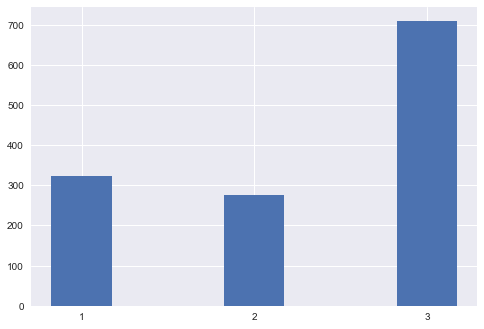

In [31]:
series = DF_T_trans['pclass'].dropna().value_counts().sort_index()
cats = series.keys().tolist()
freq = series.values.tolist()

index = np.arange(len(cats))
bar_width = 0.35

plt.bar(index, freq, bar_width)
# plt.xlabel('Embarking Port')
# plt.ylabel('Number')
plt.xticks(index, cats)

plt.show()

### Embarkation Port

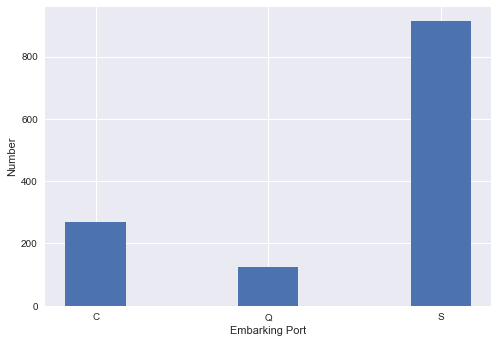

In [32]:
series = DF_T_trans['embarked'].dropna().value_counts().sort_index()
cats = series.keys().tolist()
freq = series.values.tolist()


index = np.arange(len(cats))
bar_width = 0.35

plt.bar(index, freq, bar_width)
plt.xlabel('Embarking Port')
plt.ylabel('Number')
plt.xticks(index, cats)

plt.show()

### Sex

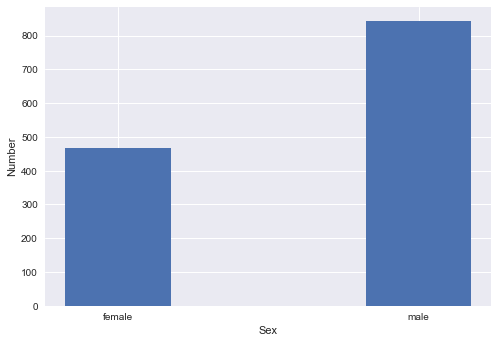

In [33]:
series = DF_T_trans['sex'].dropna().value_counts().sort_index()
cats = series.keys().tolist()
freq = series.values.tolist()


index = np.arange(len(cats))
bar_width = 0.35

plt.bar(index, freq, bar_width)
plt.xlabel('Sex')
plt.ylabel('Number')
plt.xticks(index, cats)

plt.show()

### Age

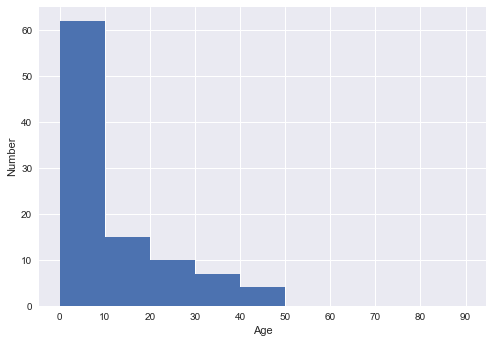

In [34]:
series = DF_T_trans['age'].dropna().value_counts().sort_index()
freq = series.values.tolist()


index = np.arange(len(cats))
bar_width = 0.35

plt.hist(freq, bins = np.arange(0,100,10))
plt.xlabel('Age')
plt.ylabel('Number')
plt.xticks(np.arange(0,100,10))
plt.show()

## Cabin

3.Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.


In the transformations, we derived the cabin floor as a seperate feature, using that, we have:

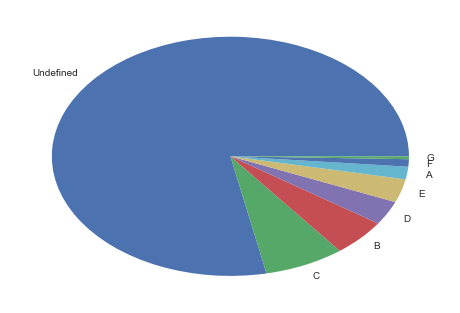

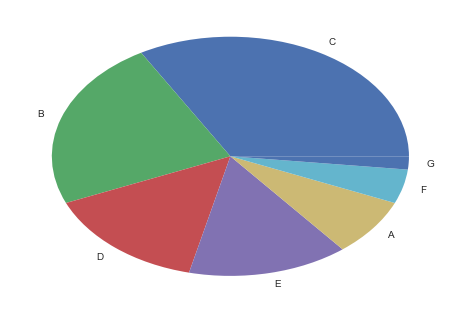

In [35]:
series = DF_T_trans.cabin_floor.value_counts()
cats = series.keys().tolist()
freq = series.values.tolist()
index = np.arange(len(cats))

plt.pie(freq, labels=cats, )
# plt.xlabel('Embarking Port')
# plt.ylabel('Number')
# plt.xticks(index, cats)
plt.show()
plt.close()

# print(type(series))
no_undefined = series.drop('Undefined')
cats = no_undefined.keys().tolist()
freq = no_undefined.values.tolist()
index = np.arange(len(cats))
plt.pie(freq, labels=cats, )
plt.show()
plt.close()

## Travel Class

4.For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

There are 3 main travel classes:

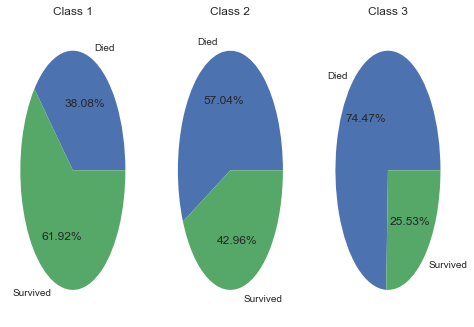

In [36]:
series = DF_T_trans.loc[DF_T_trans.pclass == 1]['survived'].value_counts().sort_index()
freq = series.values.tolist()
plt.subplot(1,3, 1)
plt.pie(freq, labels=['Died', 'Survived'], autopct='%.2f%%')
# plt.xlabel('Embarking Port')
# plt.ylabel('Number')
# plt.xticks(index, cats)
plt.title('Class 1')

series = DF_T_trans.loc[DF_T_trans.pclass == 2]['survived'].value_counts().sort_index()
freq = series.values.tolist()
plt.subplot(1,3, 2)
plt.pie(freq, labels=['Died', 'Survived'], autopct='%.2f%%')
# plt.xlabel('Embarking Port')
# plt.ylabel('Number')
# plt.xticks(index, cats)
plt.title('Class 2')

series = DF_T_trans.loc[DF_T_trans.pclass == 3]['survived'].value_counts().sort_index()
freq = series.values.tolist()
plt.subplot(1,3, 3)
plt.pie(freq, labels=['Died', 'Survived'], autopct='%.2f%%' )
# plt.xlabel('Embarking Port')
# plt.ylabel('Number')
# plt.xticks(index, cats)
plt.title('Class 3')

plt.show()
plt.close()

5.Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

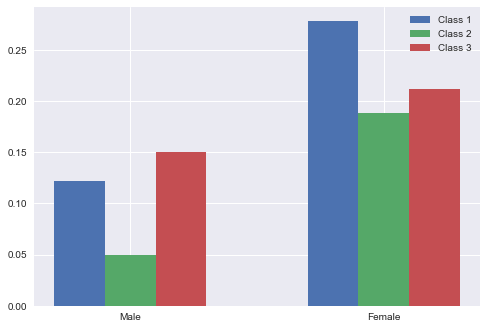

In [37]:
import seaborn

survived = DF_T_trans.loc[DF_T_trans.survived == 1]
numof_survived = len(survived)
numof_survived_male_c1 = len(survived.loc[(survived.sex == 'male') & (survived.pclass == 1)])
numof_survived_male_c2 = len(survived.loc[(survived.sex == 'male') & (survived.pclass == 2)])
numof_survived_male_c3 = len(survived.loc[(survived.sex == 'male') & (survived.pclass == 3)])
numof_survived_female_c1 = len(survived.loc[(survived.sex == 'female') & (survived.pclass == 1)])
numof_survived_female_c2 = len(survived.loc[(survived.sex == 'female') & (survived.pclass == 2)])
numof_survived_female_c3 = len(survived.loc[(survived.sex == 'female') & (survived.pclass == 3)])

c1_propotions = np.array([numof_survived_male_c1, numof_survived_female_c1]) / float(numof_survived)
c2_propotions = np.array([numof_survived_male_c2, numof_survived_female_c2]) / float(numof_survived)
c3_propotions = np.array([numof_survived_male_c3, numof_survived_female_c3]) / float(numof_survived)

bar_width = 0.2
X = np.arange(2)
plt.bar(X              , c1_propotions, width = bar_width)
plt.bar(X + bar_width  , c2_propotions, width = bar_width)
plt.bar(X + 2*bar_width, c3_propotions, width = bar_width)
plt.xticks([0.2, 1.2], ['Male', 'Female'])

plt.legend(['Class 1', 'Class 2', 'Class 3'])
plt.show()

## Binary Age Catagories

6.Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

Because of the existance of repeated ages, the qcut method does not automatically produce equally sized bins: 

In [38]:
pd.qcut(DF_T_trans.age, 2, ['young', 'old']).value_counts()

young    536
old      510
Name: age, dtype: int64

So we first break the ties with a ranking, and then do the bining: 

In [39]:
age_cat = pd.qcut(DF_T_trans.age.rank(method='first'), 2, ['young', 'old'])
age_cat.value_counts()

young    523
old      523
Name: age, dtype: int64

In [40]:
DF_T_trans = DF_T_trans.assign(age_cat=age_cat)

In [41]:
survived = DF_T_trans.loc[DF_T_trans.survived == 1]
numof_survived = len(survived)

def calculate_survival_rate(df):
    return len(df)/numof_survived

In [42]:
Survival_DF = pd.DataFrame(DF_T_trans.groupby(['age_cat', 'pclass', 'sex']).apply(calculate_survival_rate))
Survival_DF.rename(columns = {0:'Survived'})

Survived
age_cat pclass sex             
old     1      female     0.184
               male       0.238
        2      female     0.094
               male       0.168
        3      female     0.090
               male       0.272
young   1      female     0.082
               male       0.064
        2      female     0.112
               male       0.148
        3      female     0.214
               male       0.426